<h1><center>The Final Computational Neuroscience Project</center></h1>  

At first, it was tried to use the Spiking HMAX model to identify objects without the help of frameworks, but due to the low accuracy of the results, it was decided to use the SpykeTorch framework. 
First, we examine the Spiking HMAX model.

# Spiking HMAX Model 

* #### Exploring the capacity of simple feedforward network architectures:
  * Neurons in the various layers of the system fire asynchronously,with the most strongly activated neurons    firing first.
  * Neurons at later stages implement STDP learning rule. 

* #### Intermediate-level neurons will naturally become selective to patterns that are reliably present in the input, while their latencies decrease, leading to both fast and informative responses.
* #### This process occurs in an entirely unsupervised way and these intermediate features are able to support categorization.
***

## Architecture of Spiking-HMAX 

<div>
<img src="SpykeTorch/hmax.png" width="400" style="float:right;"/>
</div>
<div style="clear:left;"></div>

* #### Uses spiking neurons and operates in temporal domain.
* #### Five-layer hierarchical network (S1 → C1 → S2 → C2 → classifier ).
* #### Alternating simple and complex cells
* #### Five processing scales
* #### Spiking neurons (Integrate & Fire model) and STDP learning rule.
* #### Input stimulus is encoded by Intensity-to-Latency conversion.
* #### Stimuli are processed one-by-one and only the first spike (if any) is considered for each stimulus.
* #### Restricted receptive fields and weight sharing mechanism (convolutional network).
***

###  S1 layer:
* Detect bars and edges in four preferred orientations (emulating V1 simple cells).
* Five scaled versions of the image (with the same filter size) but in this project we just use one size.
* Emits a spike using Intensity-to-Latency conversion (time-to-first-spike coding).
* The spike of the best matching orientation is propagated (winner-take-all inhibition that increases the    latency of neighboring cells).

### C1 layer:
* Performing local max operation by simply propagating the first spike emitted by a given group of presynaptic S1 cells.

### S2 layer:
* Learning intermediate-complexity visual features.
* Weighted combination of bars (C1 cells) with different orientations.
* Weight-sharing mechanism with restricted receptive fields (4 × s × s).
* Separate processing scale.
* Winner-take-all lateral inhibition at the same processing scale (within an s / 2 × s / 2 square neighborhood of the firing position).
* The winner cell fires and triggers the STDP.
* A simplified version of STDP is used (Flat-STDP where only the sign matters).

### C2 layer
* Performing global max operation through the first spike over all positions and scales,leading to the global position- and scale-invariant responses.
***

Our model is a little different from the Spiking HMAX model. In the following, we will explain what we did in each section.

In [3]:
import SpykeTorch.utils as utils
import SpykeTorch.utils as utils
import SpykeTorch.functional as sf
import torchvision.transforms as transforms
import numpy as np

First we change the size of the photos so that we can work with a large amount of data and run the program faster.
Implementation of layer S1:
* grayscale image
* convert to tensor (usable for PyTorch)
* Gabor filters 
* lateral inhibition
* intencity-to-latency encoding

All in all, the whole image to spike-wave transform can be written as a composition of several transforms:   

In [4]:
from torchvision.datasets import ImageFolder

theta = np.arange(0, np.pi, np.pi/4) # range of theta
kernels = [ utils.GaborKernel(window_size = 3, orientation = theta[0]),
            utils.GaborKernel(3, theta[1]),
            utils.GaborKernel(3, theta[2]),
            utils.GaborKernel(3, theta[3])]

filter = utils.Filter(kernels, use_abs = True)

#To add a new dimension to the tensor
def time_dim(input):
    return input.unsqueeze(0)

#generates the spike-wave tensor based on intensities
transform = transforms.Compose(
    [transforms.Grayscale(),
    transforms.ToTensor(),
    time_dim,
    filter,
    sf.pointwise_inhibition,
    utils.Intensity2Latency(number_of_spike_bins = 15, to_spike = True)])

dataset = ImageFolder("dataset/coltech", transform) # adding transform to the dataset

### we shuffle and split the whole dataset into two training (75%) and testing (25%) parts.

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import random

# splitting training and testing sets
indices = list(range(len(dataset)))
random.shuffle(indices)
split_point = int(0.75*len(indices))
train_indices = indices[:split_point]
test_indices = indices[split_point:]

dataset = utils.CacheDataset(dataset)
train_loader = DataLoader(dataset, sampler=SubsetRandomSampler(train_indices))
test_loader = DataLoader(dataset, sampler=SubsetRandomSampler(test_indices))

print("Size of the training set:", len(train_indices))
print("Size of the  testing set:", len(test_indices))

Size of the training set: 1220
Size of the  testing set: 407


####  C1 is a local pooling and S2 is a trainable convolutional layer.
* Layer C1 performs local pooling with window-size = 3 and stride = 2
* Layer S2 performs a convolutional layer with 100 features and kernel-size equal to the size of the C1's output. 
*  we train and evaluate layer S2 using STDP.

In [6]:
import SpykeTorch.snn as snn

pool = snn.Pooling(kernel_size = 3, stride = 2)
conv = snn.Convolution(in_channels=4, out_channels=100, kernel_size=30)
stdp = snn.STDP(conv_layer = conv, learning_rate = (0.05, -0.015))

### STDP learning:
After converting the output of the S2 layer to spikes, we use the Winner function to find the winning neurons that act on the time of spike(the earliest) and their potential(maximum) in the second step. Then we apply the learning action and finally we enter the evaluation stage.

In [8]:
corr = []
print("STDP learning:")
for iter in range(50):
    print('\rIteration:', iter, end="")
    for data,targets in train_loader:
        for x in data:
            x = pool(x)
            p = conv(x)
            o, p = sf.fire(p, 40, return_thresholded_potentials=True)
            winners = sf.get_k_winners(p, kwta=3, inhibition_radius=0, spikes=o)
            stdp(x, p, o, winners)
            #use for RDM
            if iter== 49:
                corr.append([targets.cpu().numpy(),p.reshape(-1).cpu().numpy()])

STDP learning:
Iteration: 49

### Features Extracted in S2 layer:

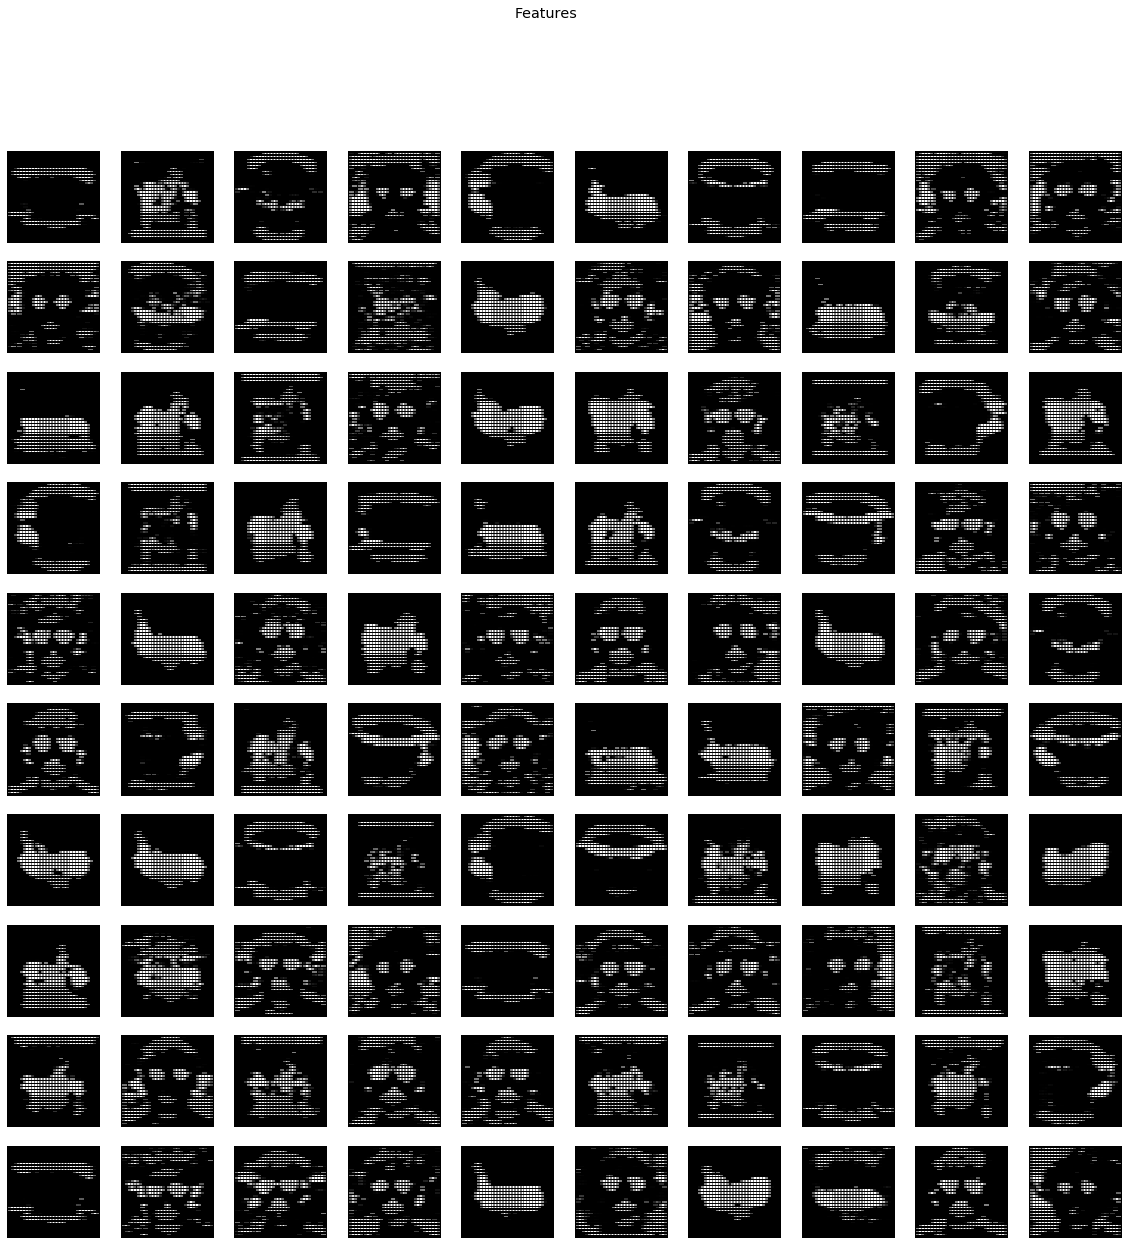

In [9]:
import SpykeTorch.visualization as vis
import torch
import matplotlib.pyplot as plt


feature = torch.stack([k() for k in kernels])
cstride = (1,1)
# C1 Features #
feature,cstride = vis.get_deep_feature(feature, cstride, (3, 3), (2, 2))
# S2 Features #
feature,cstride = vis.get_deep_feature(feature, cstride, (30,30), (1,1), conv.weight)

feature_idx = 0
fig = plt.figure("Features", figsize=(20, 20))
fig.suptitle("Features", fontsize="x-large")

for r in range(10):
    for c in range(10):
        plt.subplot(10, 10, feature_idx+1)
        plt.axis('off'); 
        plt.imshow(feature[feature_idx].numpy(),cmap='gray')
        feature_idx += 1
plt.show()

###  Model Training, Prediction:

In [10]:
train_x_spike = []
train_x_pot = []
train_y = []
for data,targets in train_loader:
    for x,t in zip(data, targets):
        x = pool(x)
        p = conv(x)
        o = sf.fire(p, 40)
        train_x_spike.append(o.reshape(-1).cpu().numpy())
        train_x_pot.append(p.reshape(-1).cpu().numpy())
        train_y.append(t)
train_x_spike = np.array(train_x_spike)
train_x_pot = np.array(train_x_pot)
train_y = np.array(train_y)
##############################################################################
test_x_spike = []
test_x_pot = []
test_y = []
for data,targets in test_loader:
    for x,t in zip(data, targets):
        x = pool(x)
        p = conv(x)
        o = sf.fire(p, 40)
        test_x_spike.append(o.reshape(-1).cpu().numpy())
        test_x_pot.append(p.reshape(-1).cpu().numpy())
        test_y.append(t)
test_x_spike = np.array(test_x_spike)
test_x_pot = np.array(test_x_pot)
test_y = np.array(test_y)

### External Classifier (SVM):

In [11]:
from sklearn.svm import LinearSVC

clf_spike = LinearSVC(max_iter=100000)
clf_pot = LinearSVC(max_iter=100000)
clf_spike.fit(train_x_spike, train_y)
clf_pot.fit(train_x_pot, train_y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=100000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

###  Performance Evaluation:

In [12]:
from sklearn import metrics
import pandas as pd

train_spike = clf_spike.predict(train_x_spike)
train_pot =  clf_pot.predict(train_x_pot)
predict_spike = clf_spike.predict(test_x_spike)
predict_pot = clf_pot.predict(test_x_pot)

error_spike = np.abs(test_y - predict_spike).sum()
error_pot = np.abs(test_y - predict_pot).sum()
print("    Spike-based error:", error_spike/len(predict_spike))
print("Potential-based error:", error_pot/len(predict_pot))


def eval_model(predictions=None,test_y=None):
    classes=[0,1,2,3]
    #\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    print('Model Performance metrics:')
    print('-'*30)
    print('Accuracy:', np.round(metrics.accuracy_score(test_y,predictions),4))
    print('Precision:', np.round(metrics.precision_score(test_y, predictions,average='weighted'),4))
    print('Recall:', np.round(metrics.recall_score(test_y,predictions,average='weighted'),4))
    print('F1 Score:', np.round(metrics.f1_score(test_y,predictions,average='weighted'),4))

    #\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    print('\nModel Classification report:')
    print('-'*30)
    report = metrics.classification_report(y_true=test_y, y_pred=predictions,labels=classes) 
    print(report)

    #\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    total_classes = len(classes)
    class_tag = ['airplanes','cup','Faces_easy','Motorbikes']
    level_labels = [total_classes*[0], list(range(total_classes))]
    cm = metrics.confusion_matrix(y_true=test_y, y_pred=predictions,labels=classes)
    cm_frame = pd.DataFrame(data=cm,columns=pd.MultiIndex(levels=[['Predicted:'],class_tag],\
                                                          codes=level_labels),\
                            index=pd.MultiIndex(levels=[['Actual:'], class_tag], codes=level_labels))
    print(cm_frame)
    
print('='*30)    
print("Spike-based for test data:") 
print('='*30)
eval_model(predict_spike,test_y)
print('='*30)
print("Potential-based for test data:")
print('='*30)
eval_model(predict_pot,test_y)  
print('='*30)
print("Spike-based for train data:")
print('='*30)
eval_model(train_spike,train_y)
print('='*30)
print("Potential-based for train data:")
print('='*30)
eval_model(train_pot,train_y)


    Spike-based error: 0.3046683046683047
Potential-based error: 0.009828009828009828
Spike-based for test data:
Model Performance metrics:
------------------------------
Accuracy: 0.8501
Precision: 0.8513
Recall: 0.8501
F1 Score: 0.8505

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          0       0.79      0.78      0.78       114
          1       0.89      0.87      0.88       102
          2       0.94      0.90      0.92        84
          3       0.81      0.86      0.84       107

avg / total       0.85      0.85      0.85       407


Prediction Confusion Matrix:
------------------------------
                   Predicted:                          
                    airplanes cup Faces_easy Motorbikes
Actual: airplanes          89   9          4         12
        cup                 8  89          0          5
        Faces_easy          2   2         76          4
        Motorbikes         14   0      

In [13]:
conv.reset_weight()
conv = snn.Convolution(in_channels=4, out_channels=200, kernel_size=30)
stdp = snn.STDP(conv_layer = conv, learning_rate = (0.05, -0.015))
anti_stdp = snn.STDP(conv_layer = conv, learning_rate = (-0.05, 0.0005))
feature2class = [0] * 50 + [1] * 50 + [2] * 50 + [3] * 50

###  R-STDP Learning:

In [14]:
corr2 = []
print("R-STDP Learning:")
for iter in range(50):
    print('\rIteration:', iter, end="")
    for data,targets in train_loader:
        for x,t in zip(data, targets):
            x = pool(x)
            p = conv(x)
            o, p = sf.fire(p, 40, return_thresholded_potentials=True)
            winners = sf.get_k_winners(p, kwta=3, inhibition_radius=0, spikes=o)
            if len(winners) != 0:
                if feature2class[winners[0][0]] == t:
                    stdp(x, p, o, winners)
                else:
                    anti_stdp(x, p, o, winners)
            if iter== 49:
                corr2.append([t.cpu().numpy(),p.reshape(-1).cpu().numpy()])        
print()

R-STDP Learning:
Iteration: 49


### Features Extracted in S2 layer:

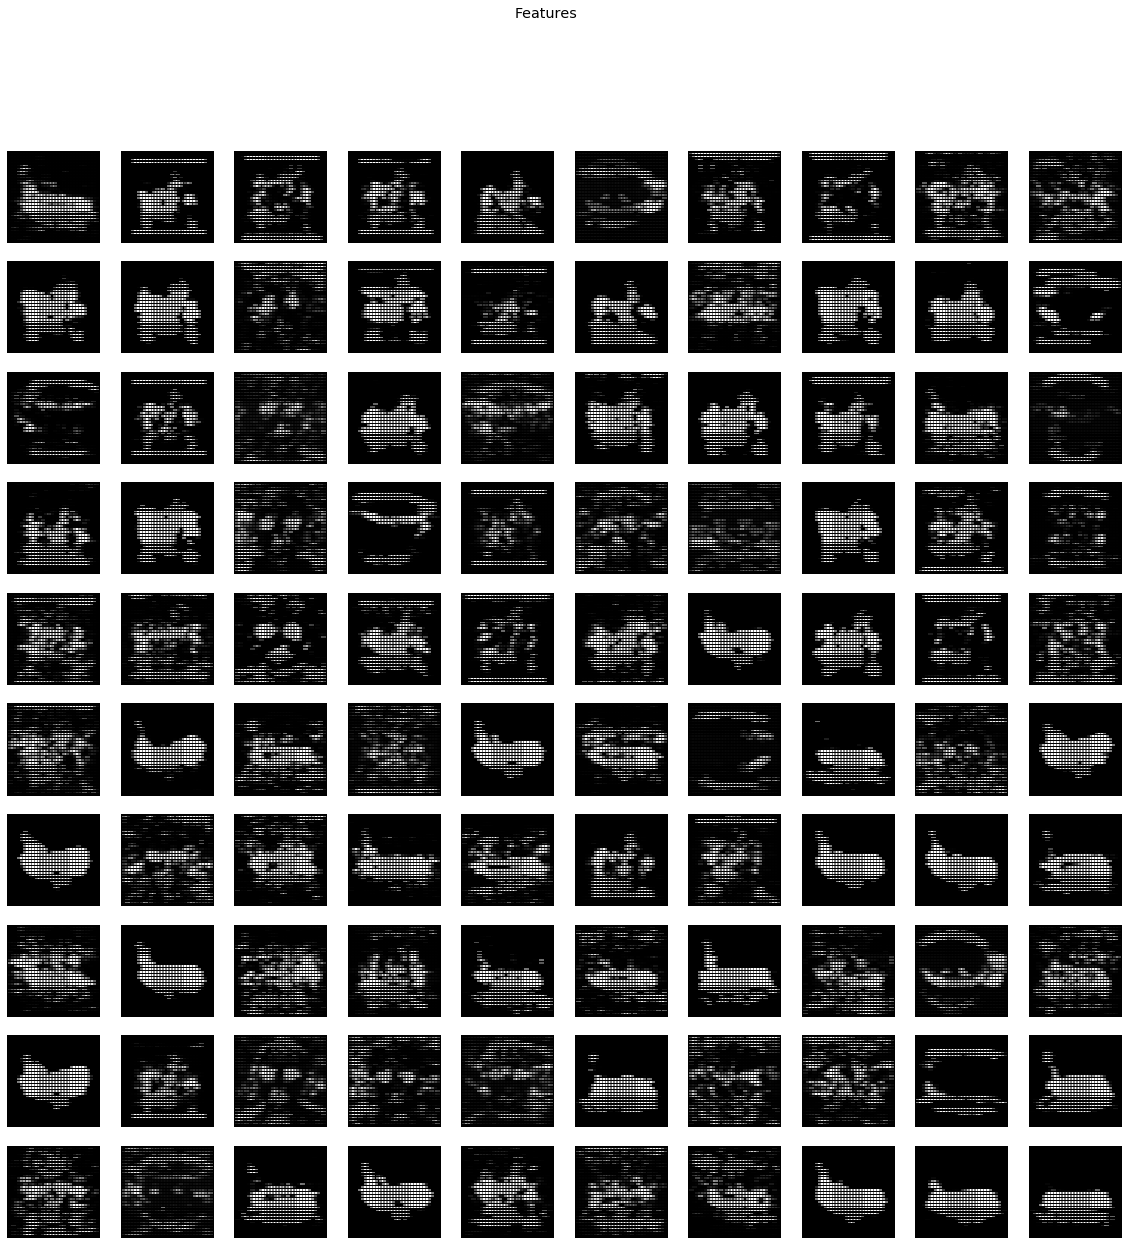

In [15]:
import SpykeTorch.visualization as vis
import torch

feature = torch.stack([k() for k in kernels])
cstride = (1,1)
# C1 Features #
feature,cstride = vis.get_deep_feature(feature, cstride, (3, 3), (2, 2))
# S2 Features #
feature,cstride = vis.get_deep_feature(feature, cstride, (30,30), (1,1), conv.weight)

feature_idx = 0
fig = plt.figure("Features", figsize=(20, 20))
fig.suptitle("Features", fontsize="x-large")

for r in range(10):
    for c in range(10):
        ax = plt.subplot(10, 10, feature_idx+1)
        plt.axis('off')
        plt.imshow(feature[feature_idx].numpy(),cmap='gray')
        feature_idx += 1


### Performance Evaluation for Test-Data:

In [16]:
from sklearn import metrics
import pandas as pd


error = 0
silent = 0
total = 0
predictions = []
test_y = []
for data,targets in test_loader:
    for x,t in zip(data, targets):
        total += 1
        x = pool(x)
        p = conv(x)
        o, p = sf.fire(p, 40, return_thresholded_potentials=True)
        winners = sf.get_k_winners(p, kwta=3, inhibition_radius=0, spikes=o)
        predictions.append(feature2class[winners[0][0]])
        test_y.append(t)    
        if len(winners) != 0:
            if feature2class[winners[0][0]] != t:
                error += 1
        else:
            silent += 1
print("         Error:", error/total)
print("Silent Samples:", silent/total)



classes=[0,1,2,3]
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
print('Accuracy:', np.round(metrics.accuracy_score(test_y,predictions),4))
print('Precision:', np.round(metrics.precision_score(test_y, predictions,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(test_y,predictions,average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(test_y,predictions,average='weighted'),4))

#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
report = metrics.classification_report(y_true=test_y, y_pred=predictions,labels=classes) 
print(report)

#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
total_classes = len(classes)
level_labels = [total_classes*[0], list(range(total_classes))]
class_tag = ['airplanes','cup','Faces_easy','Motorbikes']
cm = metrics.confusion_matrix(y_true=test_y, y_pred=predictions,labels=classes)
cm_frame = pd.DataFrame(data=cm,columns=pd.MultiIndex(levels=[['Predicted:'], class_tag],codes=level_labels),\
                        index=pd.MultiIndex(levels=[['Actual:'], class_tag], codes=level_labels))
print(cm_frame)

         Error: 0.08108108108108109
Silent Samples: 0.0
Accuracy: 0.9189
Precision: 0.9253
Recall: 0.9189
F1 Score: 0.9185
             precision    recall  f1-score   support

          0       0.84      1.00      0.91       114
          1       0.94      0.88      0.91       102
          2       0.96      0.81      0.88        84
          3       0.98      0.95      0.97       107

avg / total       0.93      0.92      0.92       407

                   Predicted:                          
                    airplanes cup Faces_easy Motorbikes
Actual: airplanes         114   0          0          0
        cup                11  90          1          0
        Faces_easy          9   5         68          2
        Motorbikes          2   1          2        102


### Performance Evaluation for Train-Data:

In [17]:
from sklearn import metrics
import pandas as pd


error = 0
silent = 0
total = 0
predictions = []
train_y = []
for data,targets in train_loader:
    for x,t in zip(data, targets):
        total += 1
        x = pool(x)
        p = conv(x)
        o, p = sf.fire(p, 40, return_thresholded_potentials=True)
        winners = sf.get_k_winners(p, kwta=3, inhibition_radius=0, spikes=o)
        predictions.append(feature2class[winners[0][0]])
        train_y.append(t)    
        if len(winners) != 0:
            if feature2class[winners[0][0]] != t:
                error += 1
        else:
            silent += 1
print("         Error:", error/total)
print("Silent Samples:", silent/total)



classes=[0,1,2,3]
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
print('Accuracy:', np.round(metrics.accuracy_score(train_y,predictions),4))
print('Precision:', np.round(metrics.precision_score(train_y, predictions,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(train_y,predictions,average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(train_y,predictions,average='weighted'),4))

#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
report = metrics.classification_report(y_true=train_y, y_pred=predictions,labels=classes) 
print(report)

#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
total_classes = len(classes)
level_labels = [total_classes*[0], list(range(total_classes))]
class_tag = ['airplanes','cup','Faces_easy','Motorbikes']
cm = metrics.confusion_matrix(y_true=train_y, y_pred=predictions,labels=classes)
cm_frame = pd.DataFrame(data=cm,columns=pd.MultiIndex(levels=[['Predicted:'], class_tag],codes=level_labels),\
                        index=pd.MultiIndex(levels=[['Actual:'], class_tag], codes=level_labels))
print(cm_frame)

         Error: 0.11721311475409836
Silent Samples: 0.0
Accuracy: 0.8828
Precision: 0.8849
Recall: 0.8828
F1 Score: 0.8828
             precision    recall  f1-score   support

          0       0.86      0.90      0.88       328
          1       0.86      0.93      0.89       307
          2       0.87      0.83      0.85       257
          3       0.95      0.86      0.90       328

avg / total       0.88      0.88      0.88      1220

                   Predicted:                           
                    airplanes  cup Faces_easy Motorbikes
Actual: airplanes         294   22          7          5
        cup                15  286          4          2
        Faces_easy         18   16        214          9
        Motorbikes         14    9         22        283


### RDM:

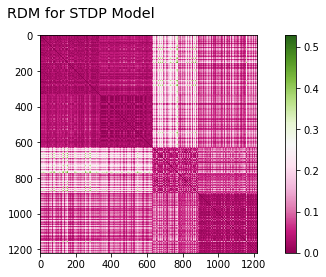

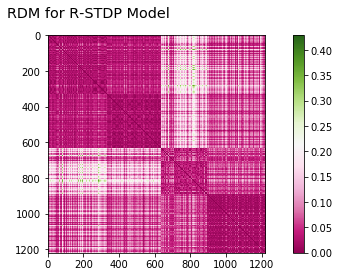

In [19]:
import scipy.stats
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.stats import norm

def comput_corr(corr=None):
    sorted_corr = sorted(corr,key=lambda l:l[0])
    dis_mat = np.array(sorted_corr)
    final_mat=dis_mat[:,1]
    mat_diss = []
    for i in range(len(final_mat)):
        mat_diss.append(final_mat[i])
    diss = np.corrcoef(mat_diss)  
    return 1 - diss
    

    
diss_stdp = comput_corr(corr)
diss_rstdp = comput_corr(corr2)

fig = plt.figure("RDM for STDP Model", figsize=(10, 4))
fig.suptitle("RDM for STDP Model", fontsize="x-large")
plt.imshow(diss_stdp, cmap="PiYG")
plt.colorbar()  
fig = plt.figure("RDM for R-STDP Model", figsize=(10, 4))
fig.suptitle("RDM for R-STDP Model", fontsize="x-large")
plt.imshow(diss_rstdp, cmap="PiYG")
plt.colorbar() 

Sharare Zolghadr (610395109)                                                                                   
Computational Neuroscience